## Bayesian Optimisation 

source: https://machinelearningmastery.com/what-is-bayesian-optimization/

In [1]:
# example of bayesian optimization for a 1d function 
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

In [2]:
# objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return (x**2 * sin(5 * pi * x)**6.0) + noise

In [3]:
# grid-based sample of the domain [0,1]
X = arange(0, 1, 0.01)

In [4]:
# sample the domain without noise
y = [objective(x, 0) for x in X]

In [5]:
# sample the domain with noise
ynoise = [objective(x) for x in X]

In [6]:
# find best result
ix = argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

Optima: x=0.900, y=0.810


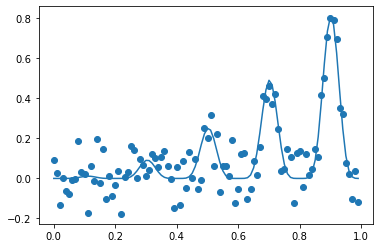

In [7]:
# plot the points with noise
pyplot.scatter(X, ynoise)
# plot the points without noise
pyplot.plot(X, y)
# show the plot
pyplot.show()

In [8]:
# surrogate (approximation) for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

In [9]:
# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()

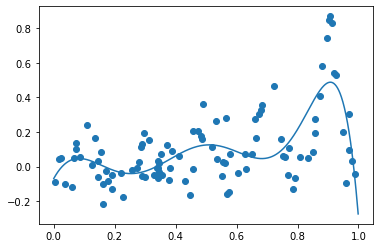

In [10]:
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function
plot(X, y, model)

In [11]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

In [12]:
# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]

In [13]:
# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()

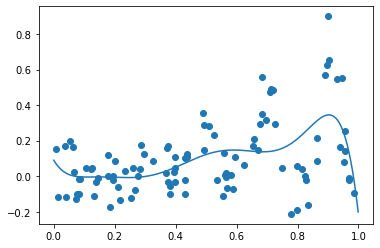

In [14]:
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)

In [15]:
# perform the optimization process
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)

>x=0.903, f()=0.345025, actual=0.749
>x=0.131, f()=-0.003226, actual=0.020
>x=0.359, f()=0.022874, actual=-0.177
>x=0.904, f()=0.380937, actual=0.903
>x=0.458, f()=0.095378, actual=0.108
>x=0.760, f()=0.167027, actual=0.085
>x=0.215, f()=-0.013291, actual=-0.058
>x=0.903, f()=0.423365, actual=0.670
>x=0.222, f()=-0.017999, actual=0.063
>x=0.852, f()=0.362761, actual=-0.027
>x=0.130, f()=0.003239, actual=0.087
>x=0.892, f()=0.414055, actual=0.807
>x=0.904, f()=0.447260, actual=0.754
>x=0.795, f()=0.218195, actual=0.057
>x=0.437, f()=0.083122, actual=-0.118
>x=0.998, f()=-0.353362, actual=-0.050
>x=0.908, f()=0.451144, actual=0.700
>x=0.218, f()=-0.010830, actual=-0.053
>x=0.866, f()=0.399074, actual=0.279
>x=0.122, f()=0.008596, actual=-0.032
>x=0.452, f()=0.087615, actual=0.070
>x=0.688, f()=0.109477, actual=0.502
>x=0.911, f()=0.456325, actual=0.664
>x=0.299, f()=-0.023204, actual=0.028
>x=0.911, f()=0.466948, actual=0.733
>x=0.067, f()=0.003430, actual=0.095
>x=0.854, f()=0.380825, a

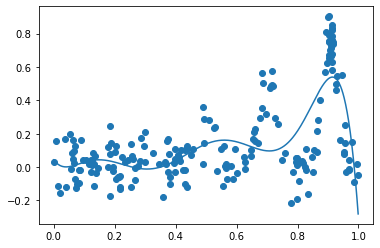

Best Result: x=0.904, y=0.903


In [16]:
# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))